# Exploratory data analysis with labeled data
Now that we have the labels for our data, we can do some initial EDA to see if there is something different between the hackers and the valid users.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )
hackers_2018.head()

,start,end,source_ip,duration,start_floor,end_ceil
0,2018-01-02 02:31:43.326264,2018-01-02 02:35:16.326264,102.139.159.128,0 days 00:03:33,2018-01-02 02:31:00,2018-01-02 02:36:00
1,2018-01-02 20:14:02.279476,2018-01-02 20:14:28.279476,119.218.239.234,0 days 00:00:26,2018-01-02 20:14:00,2018-01-02 20:15:00
2,2018-01-03 01:25:48.667114,2018-01-03 01:29:13.667114,151.93.164.203,0 days 00:03:25,2018-01-03 01:25:00,2018-01-03 01:30:00
3,2018-01-08 21:41:43.985324,2018-01-08 21:45:56.985324,226.98.192.152,0 days 00:04:13,2018-01-08 21:41:00,2018-01-08 21:46:00
4,2018-01-11 17:38:30.974748,2018-01-11 17:42:33.974748,23.81.78.129,0 days 00:04:03,2018-01-11 17:38:00,2018-01-11 17:43:00


This function will tell us if the datetimes had hacker activity:

In [2]:
def check_if_hacker(datetimes, hackers, resolution='1min'):
    """
    Check whether a hacker attempted a log in during that time.
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        `pandas.Series` of Booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series(dtype='object')
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

Let's label our data for Q1 so we can look for a separation boundary:

In [3]:
users_with_failures = logs_2018.loc['2018-Q1'].assign(
    failures=lambda x:  1 - x.success
).query('failures > 0').resample('1min').agg(
    {'username':'nunique', 'failures': 'sum'}
).dropna().rename(
    columns={'username':'usernames_with_failures'}
)
labels = check_if_hacker(users_with_failures.reset_index().datetime, hackers_2018)
users_with_failures['flag'] = labels[:users_with_failures.shape[0]].values
users_with_failures.head()

,usernames_with_failures,failures,flag
datetime,,,
2018-01-01 00:08:00,1,1,False
2018-01-01 00:09:00,0,0,False
2018-01-01 00:10:00,0,0,False
2018-01-01 00:11:00,0,0,False
2018-01-01 00:12:00,0,0,False


Since we have the labels, we can draw a sample boundary that would separate most of the hackers from the valid users:

Text(0.5, 1.0, 'Usernames with failures on minute resolution')

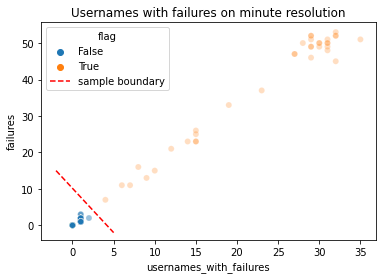

In [4]:
ax = sns.scatterplot(
    x=users_with_failures.usernames_with_failures, 
    y=users_with_failures.failures, 
    alpha=0.25,
    hue=users_with_failures.flag
)
plt.ylim(-4, None)
ax.plot([-2, 5], [15, -2], 'r--', label='sample boundary')
# sort the legend entries
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, title='flag')
plt.title('Usernames with failures on minute resolution')

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="./2-unsupervised_anomaly_detection.ipynb">
            <button>&#8592; Previous Notebook</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./4-supervised_anomaly_detection.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>